In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_gbq
from Functions.confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
#Call BigQuery

"""
1st - Call bigquery and create new dataset then tables
2nd - Upload jsons to bigquery
3rd - Query the data tables to pull in the necessary information
"""

#1 Call bigquery and create new dataset then tables

#Call BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

#credentials 
credentials = service_account.Credentials.from_service_account_file(
    '/Users/thor/Python/bigquery/project_keys/steven-data_credentials.json')

#Project id name
project_id = 'steven-data'

#create the client
client = bigquery.Client(credentials= credentials,project=project_id)

In [5]:
#Import data
sql = """
    SELECT A.sku, A.inventory, A.pieces_past_due, A.min_rec_stock,
      B.sales_1_mon, B.sales_3_mon, B.sales_6_mon,
      C.forecast_3_mon, C.forecast_6_mon,
      D.lead_time, D.potential_issue,
      E.backorder
FROM `backorder_chain_example.inventory` as A
INNER JOIN  `backorder_chain_example.sales`  as B
ON A.sku = B.sku
INNER JOIN `backorder_chain_example.forecast` as C
ON A.sku = C.sku
INNER JOIN `backorder_chain_example.inventory_ordering` as D
ON A.sku = D.sku
INNER JOIN `backorder_chain_example.backorder` as E
ON A.sku = E.sku
  """
start = time.time()

#We will imput the data from the query and re-create the dataframe we created earlier
df = pd.read_gbq(sql, dialect='standard', project_id=project_id)

end = time.time()
print("Query time was " + str(np.round((end-start)/60,2)) + " minutes")

Query time was 2.48 minutes


In [10]:
#Define X and y
y = df['backorder']
X = df.drop(columns=['backorder'])
y_classes = np.array(['no_backorder', 'Backorder'])

#Get training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Get test and dev sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

X_train = X_train.drop(columns=['sku'])
test_sku = X_test['sku']
X_test = X_test.drop(columns=['sku'])
dev_sku = X_dev['sku']
X_dev = X_dev.drop(columns=['sku'])

In [ ]:
#Try first model

#Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

#Create the model
clf = LogisticRegression(random_state=0)

#Fit the model
model = clf.fit(X_train_std, y_train)

#Test accuracy of X_test
X_dev_std = scaler.transform(X_dev)

y_dev_pred = model.predict(X_dev_std)

# Plot confusion matrix
plot_confusion_matrix(y_dev, y_dev_pred, classes=y_classes, normalize=True, title='Confusion matrix')

plt.show()

- Logistic regression appears to be good as predicting no backorder but is very innaccurate in predicting backorders. This could be due to unbalanced data.

In [13]:
#Using smote to rebalance data
from collections import Counter

#Import oversampling 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

#Resample
current_count = Counter(y_train)
print(f"Unbalanced count is {current_count}")

X_res, y_res = sm.fit_resample(X_train, y_train)

resampled_count = Counter(y_res)
print(f"Rebalanced count is {resampled_count}")

#Standardize
scaler = StandardScaler()
X_res_std = scaler.fit_transform(X_res)

Unbalanced count is Counter({0: 1140175, 1: 59825})
Rebalanced count is Counter({0: 1140175, 1: 1140175})


/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[0.83213872 0.16786128]
 [0.31303772 0.68696228]]


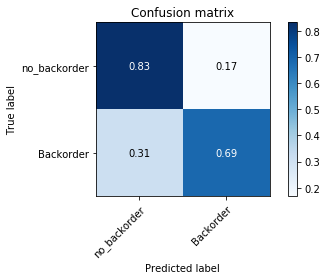

In [14]:
#Fitting the new data

#Create the model
clf = LogisticRegression(random_state=0)

#Fit the model
model = clf.fit(X_res_std, y_res)

#Test accuracy of X_test
X_dev_std = scaler.transform(X_dev)

y_dev_pred = model.predict(X_dev_std)

# Plot confusion matrix
plot_confusion_matrix(y_dev, y_dev_pred, classes=y_classes, normalize=True, title='Confusion matrix')

plt.show()

- Results are a lot better now. We have 69% accuracy in predicting backorders; however, we have sacrificed some precision in detecting classifying no backorder
- Next we can try random forest